In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint
import seaborn as sns
sns.set()
sns.despine()
from scipy import integrate

<Figure size 640x480 with 0 Axes>

In [116]:
p_temp_data = pd.read_csv('./3fungi_data/fungi_p.sang.s_temp.csv')
t_temp_data = pd.read_csv('./3fungi_data/fungi_t.chion.n_temp.csv')
x_temp_data = pd.read_csv('./3fungi_data/fungi_x.sub.s_temp.csv')
### read moisture data
p_moist_data = pd.read_csv('./3fungi_data/fungi_p.sang.s_moist.csv')
t_moist_data = pd.read_csv('./3fungi_data/fungi_t.chion.n_moist.csv')
x_moist_data = pd.read_csv('./3fungi_data/fungi_x.sub.s_moist.csv')

In [117]:
### compitition model
def diff(w, time,r_p, r_t, r_x, n_p, n_t, n_x, init_p, init_t, init_x,  s_pt, s_px, s_tp, s_tx, s_xp, s_xt):
        p, t, x = w
        return np.array([r_p * p * (1 - p / n_p - s_pt * t / n_t - s_px * x / n_x), r_t * t * (1 - t / n_t - s_tp * p / n_p - s_tx * x / n_x), r_x * x * (1 - x / n_x - s_xp * p / n_p - s_xt * t / n_t)])
    
def competition_model(r_p, r_t, r_x, p_Decomposition_rate, t_Decomposition_rate, x_Decomposition_rate , n_p, n_t, n_x, init_p, init_t, init_x, time):
    
    ### conditions: 1. 22C
    s_pt = t_Decomposition_rate/p_Decomposition_rate
    s_px = x_Decomposition_rate/p_Decomposition_rate
    s_tp = p_Decomposition_rate/t_Decomposition_rate
    s_tx = x_Decomposition_rate/t_Decomposition_rate
    s_xp = p_Decomposition_rate/x_Decomposition_rate
    s_xt = t_Decomposition_rate/x_Decomposition_rate
    ### capability of the decomposition rate of unit density of fungi
    p_capability=p_Decomposition_rate/init_p
    t_capability=t_Decomposition_rate/init_t
    x_capability=x_Decomposition_rate/init_x
    solution = odeint(diff, [init_p, init_t, init_x], time, args=(r_p, r_t, r_x, n_p, n_t, n_x, init_p, init_t, init_x, s_pt, s_px, s_tp, s_tx, s_xp, s_xt))
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.title('Competition Model for 3 Fungi density', font={'family':'Times New Roman', 'size':15})
    plt.xlabel('Time', font={'family':'Times New Roman', 'size':12}, loc='right')
    plt.ylabel('Fungi Density', font={'family':'Times New Roman', 'size':12}, loc='top')
    plt.plot(time, solution[:, 0], label='p.sang.s')
    plt.plot(time, solution[:, 1], label='t.chion.n')
    plt.plot(time, solution[:, 2], label='x.sub.s')
    plt.legend()
    
    ### The decomposition speed of the three fungi is measured by the decomposition rate of the unit density times the density of the three fungi
    p_Decomposition_speed=p_capability*solution[:,0]
    t_Decomposition_speed=t_capability*solution[:,1]
    x_Decomposition_speed=x_capability*solution[:,2]
    plt.subplot(1,3,2)
    plt.title('Decomposition Speed of 3 Fungi', font={'family':'Times New Roman', 'size':15})
    plt.plot(time, p_Decomposition_speed, label='p.sang.s')
    plt.plot(time, t_Decomposition_speed, label='t.chion.n')
    plt.plot(time, x_Decomposition_speed, label='x.sub.s')
    plt.legend()



    def calculate_wooden_fiber_remain(time, decomposition_speed, label):
        wooden_fiber_remain = [1]
        counter = 10
        flag = True
        for i in time[10:]:
            if(flag):
                x = np.linspace(0, i, counter)
                y = np.array(-decomposition_speed[:counter]
                            * wooden_fiber_remain[-1])
                # print(len(x), len(y), i)
                result = integrate.trapz(y, x)
            if(result < -1):
                wooden_fiber_remain.append(0)
                flag = False
            else:
                if(result + 1 > wooden_fiber_remain[-1]):
                    wooden_fiber_remain.append(wooden_fiber_remain[-1])
                else:
                    wooden_fiber_remain.append(1 + result)
                    counter = 1 + counter
        plt.plot(time[9:], wooden_fiber_remain, label=label)
        return 1-np.array(wooden_fiber_remain)

    plt.subplot(1,3,3)
    plt.title('Wooden Fiber Remain', font={
            'family': 'Times New Roman', 'size': 15})
    plt.ylabel("Wooden Fiber", font={
            'family': 'Times New Roman', 'size': 12}, loc='top')
    plt.xlabel("Time", font={'family': 'Times New Roman', 'size': 12}, loc='right')
    # calculate_wooden_fiber_remain(time, decomposition_speed, 'all fungi')
    p_loss = calculate_wooden_fiber_remain(time, p_Decomposition_speed, 'p.sang.s')
    t_loss = calculate_wooden_fiber_remain(time, t_Decomposition_speed, 't.chion.n')
    x_loss = calculate_wooden_fiber_remain(time, x_Decomposition_speed, 'x.sub.s')
    loss = p_loss+t_loss+x_loss
    
    plt.plot(time[9:], 1-loss, label='all fungi')
    plt.legend()
    plt.show()


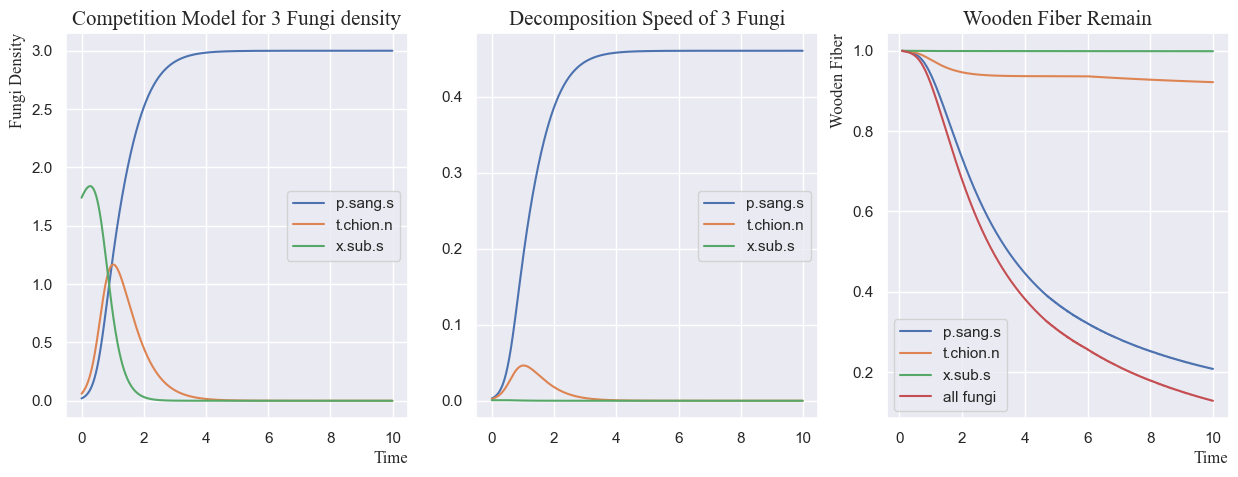

In [118]:
### data from temperature
r_p = p_temp_data[p_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_t = t_temp_data[t_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_x = x_temp_data[x_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
# print(r_p, r_t, r_x)
p_Decomposition_rate = 0.3743/122
t_Decomposition_rate = 0.2906/122
x_Decomposition_rate = 0.0855/122
n_p, n_t, n_x = 3, 3, 3
### unit of density: s micrograms dry mass per cubic centimer at 1 cm to g/m3
init_p, init_t, init_x = 0.02, 0.06, 1.74
time = np.arange(0, 10, 0.01)
competition_model(r_p, r_t, r_x, p_Decomposition_rate, t_Decomposition_rate, x_Decomposition_rate , n_p, n_t, n_x, init_p, init_t, init_x, time)

In [119]:
print("--------------------------------------------")
print("--------------------------------------------")
print("The part below is the part B")
print("The part below is the part 1: the real species data under competition model")
print("--------------------------------------------")
print("--------------------------------------------")

--------------------------------------------
--------------------------------------------
The part below is the part B
The part below is the part 1: the real species data under competition model
--------------------------------------------
--------------------------------------------


In [120]:
a1_temp_data = pd.read_csv('./3fungi_data/fungi_a.gal1.s_temp.csv')
a3_temp_data = pd.read_csv('./3fungi_data/fungi_a.gal3.s_temp.csv')
h_temp_data = pd.read_csv('./3fungi_data/fungi_h.crust.n_temp.csv')
l_temp_data = pd.read_csv('./3fungi_data/fungi_l.crin.s_temp.csv')
p_temp_data = pd.read_csv('./3fungi_data/fungi_p.har.n_temp.csv')
### read moisture data
a1_moist_data = pd.read_csv('./3fungi_data/fungi_a.gal1.s_moist.csv')
a3_moist_data = pd.read_csv('./3fungi_data/fungi_a.gal3.s_moist.csv')
h_moist_data = pd.read_csv('./3fungi_data/fungi_h.crust.n_moist.csv')
l_moist_data = pd.read_csv('./3fungi_data/fungi_l.crin.s_moist.csv')
p_moist_data = pd.read_csv('./3fungi_data/fungi_p.har.n_moist.csv')

In [121]:
### compitition model
def diff(w, time, r_a, r_f, r_h, r_l, r_m, a_Decomposition_rate, f_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, m_Decomposition_rate, n_a, n_f, n_h, n_l,n_m, s_af, s_ah, s_al, s_am, s_fa, s_fh, s_fl, s_fm, s_ha, s_hf, s_hl, s_hm, s_la, s_lf, s_lh, s_lm, s_ma, s_mf, s_mh, s_ml):
        a, f, h, l, m = w
        return np.array([r_a * a * (1 - a / n_a - s_af * f / n_f - s_ah * h / n_h - s_al * l / n_l - s_am * m / n_m), \
                            r_f * f * (1 - f / n_f - s_fa * a / n_a - s_fh * h / n_h - s_fl * l / n_l - s_fm * m / n_m), \
                            r_h * h * (1 - h / n_h - s_ha * a / n_a - s_hf * f / n_f - s_hl * l / n_l - s_hm * m / n_m), \
                            r_l * l * (1 - l / n_l - s_la * a / n_a - s_lf * f / n_f - s_lh * h / n_h - s_lm * m / n_m), \
                            r_m * m * (1 - m / n_m - s_ma * a / n_a - s_mf * f / n_f - s_mh * h / n_h - s_ml * l / n_l), ])
def competition_model(r_a, r_f, r_h, r_l, r_m, a_Decomposition_rate, f_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, m_Decomposition_rate, n_a, n_f, n_h, n_l,n_m, init_a, init_f, init_h, init_l, init_m, time):
    
    
    ### conditions: 1. 22C
    s_af, s_ah, s_al, s_am = f_Decomposition_rate/a_Decomposition_rate, h_Decomposition_rate/a_Decomposition_rate, l_Decomposition_rate/a_Decomposition_rate, m_Decomposition_rate/a_Decomposition_rate
    s_fa, s_fh, s_fl, s_fm = a_Decomposition_rate/f_Decomposition_rate, h_Decomposition_rate/f_Decomposition_rate, l_Decomposition_rate/f_Decomposition_rate, m_Decomposition_rate/f_Decomposition_rate
    s_ha, s_hf, s_hl, s_hm = a_Decomposition_rate/h_Decomposition_rate, f_Decomposition_rate/h_Decomposition_rate, l_Decomposition_rate/h_Decomposition_rate, m_Decomposition_rate/h_Decomposition_rate
    s_la, s_lf, s_lh, s_lm = a_Decomposition_rate/l_Decomposition_rate, f_Decomposition_rate/l_Decomposition_rate, h_Decomposition_rate/l_Decomposition_rate, m_Decomposition_rate/l_Decomposition_rate
    s_ma, s_mf, s_mh, s_ml = a_Decomposition_rate/m_Decomposition_rate, f_Decomposition_rate/m_Decomposition_rate, h_Decomposition_rate/m_Decomposition_rate, l_Decomposition_rate/m_Decomposition_rate

    ### capability of the decomposition rate of unit density of fungi
    a_capability=a_Decomposition_rate/init_a
    f_capability=f_Decomposition_rate/init_f
    h_capability=h_Decomposition_rate/init_h
    l_capability=l_Decomposition_rate/init_l
    m_capability=m_Decomposition_rate/init_m
    solution = odeint(diff, [init_a, init_f, init_h, init_l, init_m], time, args=(r_a, r_f, r_h, r_l, r_m, a_capability, f_capability, h_capability, l_capability, m_capability, n_a, n_f, n_h, n_l,n_m, s_af, s_ah, s_al, s_am, s_fa, s_fh, s_fl, s_fm, s_ha, s_hf, s_hl, s_hm, s_la, s_lf, s_lh, s_lm, s_ma, s_mf, s_ml, s_mh))
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.title('Competition Model for 5 Fungi density', font={'family':'Times New Roman', 'size':15})
    plt.xlabel('Time', font={'family':'Times New Roman', 'size':12}, loc='right')
    plt.ylabel('Fungi Density', font={'family':'Times New Roman', 'size':12}, loc='top')
    plt.plot(time, solution[:, 0], label='a.gal1.s')
    plt.plot(time, solution[:, 1], label='a.gal3.s')
    plt.plot(time, solution[:, 2], label='h.crust.n')
    plt.plot(time, solution[:, 3], label='l.crin.s')
    plt.plot(time, solution[:, 4], label='p.har.n')
    plt.legend()
    
    ### The decomposition speed of the three fungi is measured by the decomposition rate of the unit density times the density of the three fungi
    a_Decomposition_speed=a_capability*solution[:,0]
    f_Decomposition_speed=f_capability*solution[:,1]
    h_Decomposition_speed=h_capability*solution[:,2]
    l_Decomposition_speed=l_capability*solution[:,3]
    m_Decomposition_speed=m_capability*solution[:,4]
    plt.subplot(1,3,2)
    plt.title('Decomposition Speed of 5 Fungi', font={'family':'Times New Roman', 'size':15})
    plt.plot(time, a_Decomposition_speed, label='a.gal1.s')
    plt.plot(time, f_Decomposition_speed, label='a.gal3.s')
    plt.plot(time, h_Decomposition_speed, label='h.crust.n')
    plt.plot(time, l_Decomposition_speed, label='l.crin.s')
    plt.plot(time, m_Decomposition_speed, label='p.har.n')
    plt.legend()



    def calculate_wooden_fiber_remain(time, decomposition_speed, label):
        wooden_fiber_remain = [1]
        counter = 10
        flag = True
        for i in time[10:]:
            if(flag):
                x = np.linspace(0, i, counter)
                y = np.array(-decomposition_speed[:counter]
                            * wooden_fiber_remain[-1])
                # print(len(x), len(y), i)
                result = integrate.trapz(y, x)
            if(result < -1):
                wooden_fiber_remain.append(0)
                flag = False
            else:
                if(result + 1 > wooden_fiber_remain[-1]):
                    wooden_fiber_remain.append(wooden_fiber_remain[-1])
                else:
                    wooden_fiber_remain.append(1 + result)
                    counter = 1 + counter
        plt.plot(time[9:], wooden_fiber_remain, label=label)
        return 1-np.array(wooden_fiber_remain)

    plt.subplot(1,3,3)
    plt.title('Wooden Fiber Remain', font={
            'family': 'Times New Roman', 'size': 15})
    plt.ylabel("Wooden Fiber", font={
            'family': 'Times New Roman', 'size': 12}, loc='top')
    plt.xlabel("Time", font={'family': 'Times New Roman', 'size': 12}, loc='right')
    # calculate_wooden_fiber_remain(time, decomposition_speed, 'all fungi')
    a_loss = calculate_wooden_fiber_remain(time, a_Decomposition_speed, 'a.gal1.s')
    f_loss = calculate_wooden_fiber_remain(time, f_Decomposition_speed, 'a.gal3.s')
    h_loss = calculate_wooden_fiber_remain(time, h_Decomposition_speed, 'h.crust.n')
    l_loss = calculate_wooden_fiber_remain(time, l_Decomposition_speed, 'l.crin.s')
    m_loss = calculate_wooden_fiber_remain(time, m_Decomposition_speed, 'p.har.n')
    loss = a_loss+f_loss+h_loss+l_loss+m_loss
    
    plt.plot(time[9:], 1-loss, label='all fungi')
    plt.legend()
    plt.show()


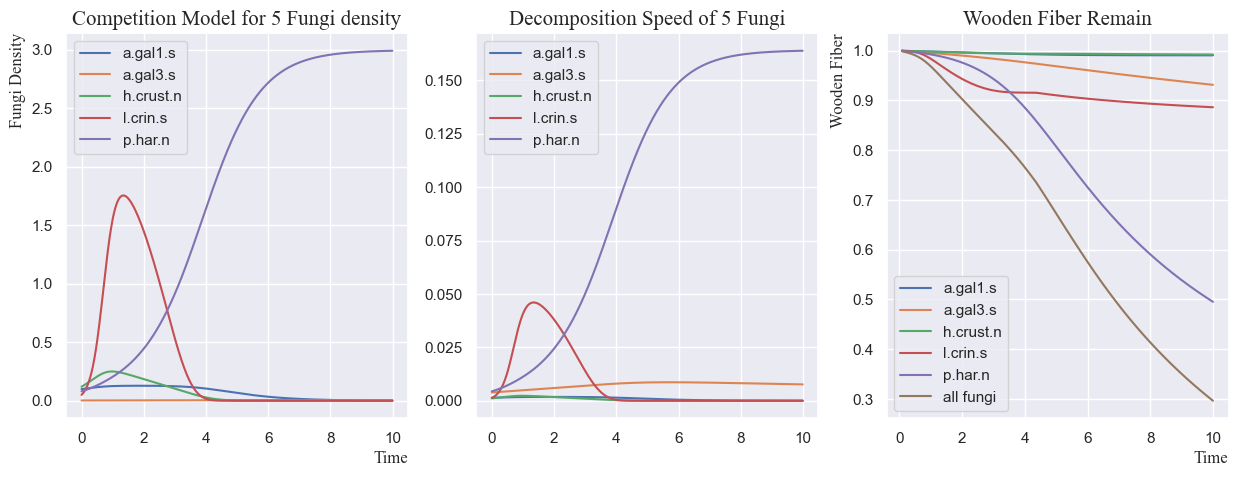

In [122]:

### data from temperature
r_a1 = a1_temp_data[p_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_a3 = a3_temp_data[t_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_h = h_temp_data[x_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_l = l_temp_data[x_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
r_p = p_temp_data[x_temp_data['temp_c'] == 22]['hyphal_rate'].values[0]
# print(r_p, r_t, r_x)
a1_Decomposition_rate = 0.1712/122
a3_Decomposition_rate = 0.4724/122
h_Decomposition_rate = 0.1362/122
l_Decomposition_rate = 0.1601/122
p_Decomposition_rate = 0.5350/122

n_a1, n_a3, n_h, n_l, n_p = 3, 3, 3, 3, 3
### unit of density: s micrograms dry mass per cubic centimer at 1 cm to g/m3
init_a1, init_a3, init_h, init_l, init_p = 0.1, 0.002375, 0.12, 0.05, 0.08
time = np.arange(0, 10, 0.01)
competition_model(r_a1, r_a3, r_h, r_l, r_p, a1_Decomposition_rate, a3_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, p_Decomposition_rate, n_a1, n_a3, n_h, n_l,n_p, init_a1, init_a3, init_h, init_l, init_p, time)

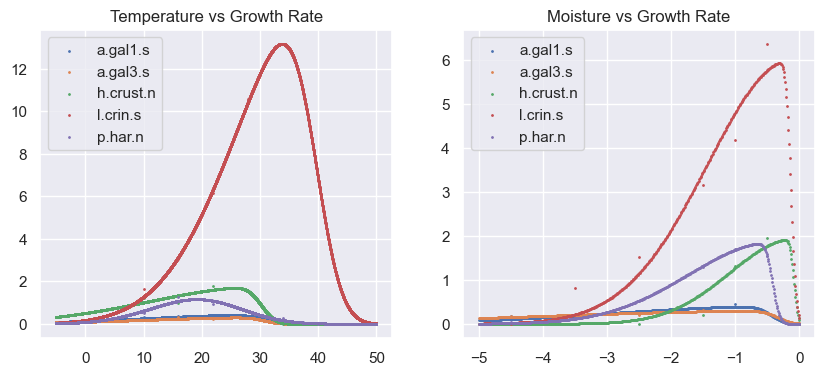

In [123]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Temperature vs Growth Rate')
plt.scatter(a1_temp_data['temp_c'], a1_temp_data['hyphal_rate'], label='a.gal1.s', s=1)
plt.scatter(a3_temp_data['temp_c'], a3_temp_data['hyphal_rate'], label='a.gal3.s', s=1)
plt.scatter(h_temp_data['temp_c'], h_temp_data['hyphal_rate'], label='h.crust.n', s=1)
plt.scatter(l_temp_data['temp_c'], l_temp_data['hyphal_rate'], label='l.crin.s', s=1)
plt.scatter(p_temp_data['temp_c'], p_temp_data['hyphal_rate'], label='p.har.n', s=1)
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Moisture vs Growth Rate')
plt.scatter(a1_moist_data['matric_pot'], a1_moist_data['hyphal_rate'], label='a.gal1.s', s=1)
plt.scatter(a3_moist_data['matric_pot'], a3_moist_data['hyphal_rate'], label='a.gal3.s', s=1)
plt.scatter(h_moist_data['matric_pot'], h_moist_data['hyphal_rate'], label='h.crust.n', s=1)
plt.scatter(l_moist_data['matric_pot'], l_moist_data['hyphal_rate'], label='l.crin.s', s=1)
plt.scatter(p_moist_data['matric_pot'], p_moist_data['hyphal_rate'], label='p.har.n', s=1)
plt.legend()
plt.show()

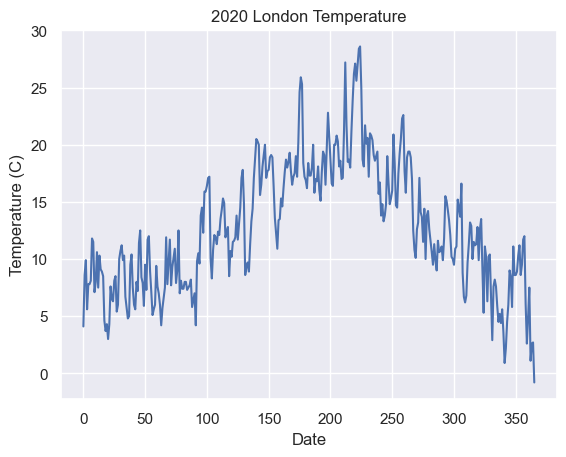

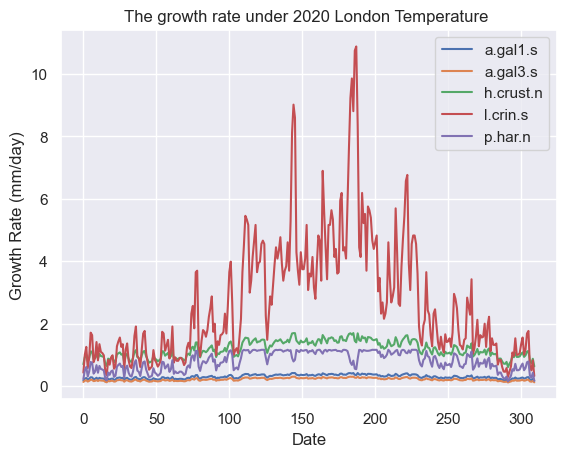

In [124]:
london_weather = pd.read_csv('./original_data/london_weather.csv')
london_temp = pd.DataFrame({"date": np.linspace(0, 365, 366), 
                            "mean_temp": london_weather["mean_temp"][-366:], 
                            "max_temp": london_weather["max_temp"][-366:], 
                            "min_temp": london_weather["min_temp"][-366:]})
london_temp = london_temp.reset_index(drop=True)
london_temp.dropna(axis = 0, subset=["mean_temp"], inplace=True)
plt.title('2020 London Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.plot(london_temp["date"], london_temp["mean_temp"])
# plt.scatter(london_temp["date"], london_temp["max_temp"])
# plt.scatter(london_temp["date"], london_temp["min_temp"])
plt.show()
a1, a3, hc, lc, ph = [], [], [], [], []

for temp in london_temp["mean_temp"]:
    if(len(a1_temp_data[a1_temp_data["temp_c"] == temp]["hyphal_rate"].values) > 0):
        a1.append(a1_temp_data[a1_temp_data["temp_c"] == temp]["hyphal_rate"].values[0])
    if(len(a3_temp_data[a3_temp_data["temp_c"] == temp]["hyphal_rate"].values) > 0):
        a3.append(a3_temp_data[a3_temp_data["temp_c"] == temp]["hyphal_rate"].values[0])
    if(len(h_temp_data[h_temp_data["temp_c"] == temp]["hyphal_rate"].values) > 0):
        hc.append(h_temp_data[h_temp_data["temp_c"] == temp]["hyphal_rate"].values[0])
    if(len(l_temp_data[l_temp_data["temp_c"] == temp]["hyphal_rate"].values) > 0):
        lc.append(l_temp_data[l_temp_data["temp_c"] == temp]["hyphal_rate"].values[0])
    if(len(p_temp_data[p_temp_data["temp_c"] == temp]["hyphal_rate"].values) > 0):
        ph.append(p_temp_data[p_temp_data["temp_c"] == temp]["hyphal_rate"].values[0])
plt.title('The growth rate under 2020 London Temperature ')
plt.xlabel('Date')
plt.ylabel('Growth Rate (mm/day)')
plt.plot(np.arange(0, len(a1)), a1, label="a.gal1.s")
plt.plot(np.arange(0, len(a3)), a3, label="a.gal3.s")
plt.plot(np.arange(0, len(hc)), hc, label="h.crust.n")
plt.plot(np.arange(0, len(lc)), lc, label="l.crin.s")
plt.plot(np.arange(0, len(ph)), ph, label="p.har.n")
plt.legend()
plt.show()

In [125]:
print(len(a1), len(a3), len(hc), len(lc), len(ph))

310 310 310 310 310


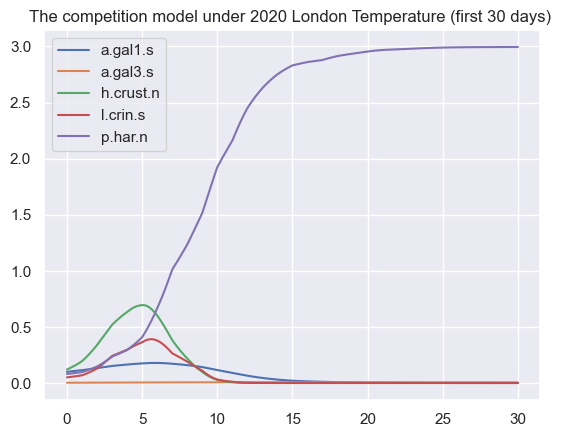

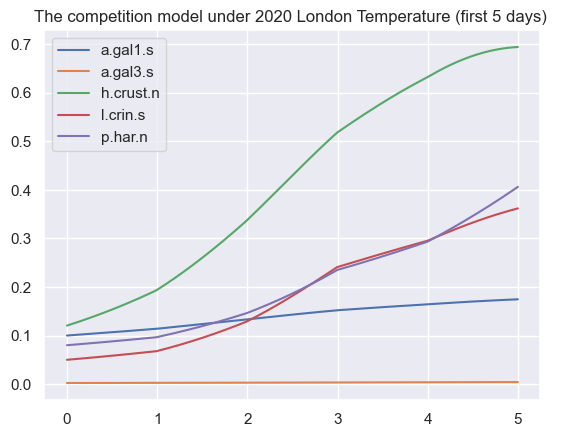

In [140]:
def flunc_model(r_a, r_f, r_h, r_l, r_m, a_Decomposition_rate, f_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, m_Decomposition_rate, n_a, n_f, n_h, n_l,n_m, init_a, init_f, init_h, init_l, init_m, time, new_init):
    time_list = [np.arange(0, 0.01, 0.001)]*100
    solution_list = []
    new_init = new_init
    s_af, s_ah, s_al, s_am = f_Decomposition_rate/a_Decomposition_rate, h_Decomposition_rate/a_Decomposition_rate, l_Decomposition_rate/a_Decomposition_rate, m_Decomposition_rate/a_Decomposition_rate
    s_fa, s_fh, s_fl, s_fm = a_Decomposition_rate/f_Decomposition_rate, h_Decomposition_rate/f_Decomposition_rate, l_Decomposition_rate/f_Decomposition_rate, m_Decomposition_rate/f_Decomposition_rate
    s_ha, s_hf, s_hl, s_hm = a_Decomposition_rate/h_Decomposition_rate, f_Decomposition_rate/h_Decomposition_rate, l_Decomposition_rate/h_Decomposition_rate, m_Decomposition_rate/h_Decomposition_rate
    s_la, s_lf, s_lh, s_lm = a_Decomposition_rate/l_Decomposition_rate, f_Decomposition_rate/l_Decomposition_rate, h_Decomposition_rate/l_Decomposition_rate, m_Decomposition_rate/l_Decomposition_rate
    s_ma, s_mf, s_mh, s_ml = a_Decomposition_rate/m_Decomposition_rate, f_Decomposition_rate/m_Decomposition_rate, h_Decomposition_rate/m_Decomposition_rate, l_Decomposition_rate/m_Decomposition_rate
    for time in time_list:
        solution = odeint(diff, new_init, time, args=(r_a1, r_a3, r_h, r_l, r_p, a1_Decomposition_rate, a3_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, p_Decomposition_rate, n_a1, n_a3, n_h, n_l,n_p,\
            s_af, s_ah, s_al, s_am,\
                s_fa, s_fh, s_fl, s_fm,\
                    s_ha, s_hf, s_hl, s_hm, \
                        s_la, s_lf, s_lh, s_lm, \
                            s_ma, s_mf, s_mh, s_ml))
        solution = solution[-1]
        new_init = solution
        solution_list.append(solution)
    return solution_list
solution_list = []
new_init = [init_a1, init_a3, init_h, init_l, init_p]
for time in range(30):
    r_a1, r_a3, r_h, r_l, r_p = a1[time], a3[time], hc[time], lc[time], ph[time]
    temporary_solution_list = flunc_model(r_a1, r_a3, r_h, r_l, r_p, a1_Decomposition_rate, a3_Decomposition_rate, h_Decomposition_rate, l_Decomposition_rate, p_Decomposition_rate, n_a1, n_a3, n_h, n_l,n_p, init_a1, init_a3, init_h, init_l, init_p, time, new_init)
    new_init = temporary_solution_list[-1]
    solution_list = solution_list + temporary_solution_list
solution_list = np.array(solution_list)
a1_solution, a3_solution, h_solution, l_solution, p_solution = solution_list[:, 0], solution_list[:, 1], solution_list[:, 2], solution_list[:, 3], solution_list[:, 4]
plt.title('The competition model under 2020 London Temperature (first 30 days) ')
plt.plot(np.linspace(0, 30 ,len(a1_solution)), a1_solution, label="a.gal1.s")
plt.plot(np.linspace(0, 30, len(a3_solution)), a3_solution, label="a.gal3.s")
plt.plot(np.linspace(0, 30, len(h_solution)), h_solution, label="h.crust.n")
plt.plot(np.linspace(0, 30, len(l_solution)), l_solution, label="l.crin.s")
plt.plot(np.linspace(0, 30, len(p_solution)), p_solution, label="p.har.n")
plt.legend()
plt.show()
plt.title('The competition model under 2020 London Temperature (first 5 days) ')
plt.plot(np.linspace(0, 5, 500), a1_solution[:500], label="a.gal1.s")
plt.plot(np.linspace(0, 5, 500), a3_solution[:500], label="a.gal3.s")
plt.plot(np.linspace(0, 5, 500), h_solution[:500], label="h.crust.n")
plt.plot(np.linspace(0, 5, 500), l_solution[:500], label="l.crin.s")
plt.plot(np.linspace(0, 5, 500), p_solution[:500], label="p.har.n")
plt.legend()
plt.show()

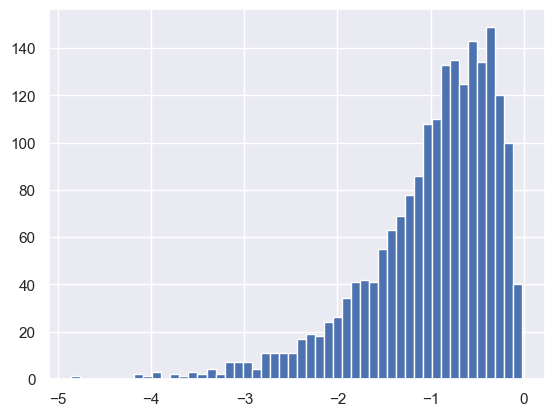

In [127]:
shape, scale = 2, 2
s = np.random.gamma(shape, scale, 2000) / -4
plt.hist(s, 50)
plt.show()